Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.3808 - loss: 1.0647 - val_accuracy: 0.5104 - val_loss: 1.3671
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7820 - loss: 0.3299 - val_accuracy: 0.6288 - val_loss: 1.7804
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9360 - loss: 0.1695 - val_accuracy: 0.6304 - val_loss: 1.5397
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9477 - loss: 0.1101 - val

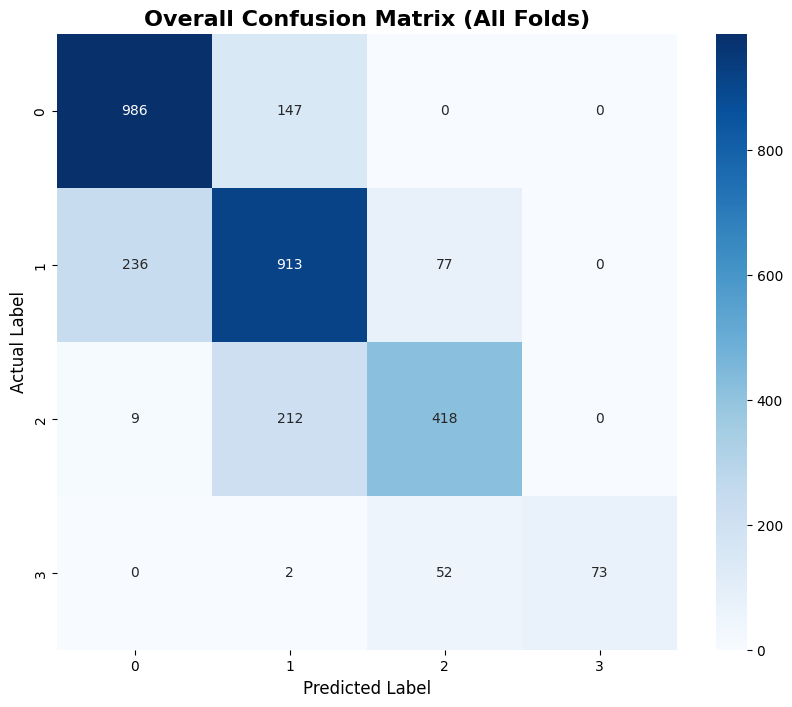

Confusion Matrix plot displayed.


--- Training Final Model on All Data for Prediction ---
Final Class Weights: {0: np.float64(0.7243243243243244), 1: np.float64(0.5747549019607843), 2: np.float64(1.343839541547278), 3: np.float64(7.3858267716535435)}
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5931 - loss: 0.8071
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8832 - loss: 0.2578
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9097 - loss: 0.1985
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9253 - loss: 0.1499
Epoch 5/30
 1/59 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9062 - loss: 0.2466

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

# **TUNED HYPERPARAMETER**: Changed time_step to 90
time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train the Model with Cross-Validation ---

# Use TimeSeriesSplit for robust cross-validation on time-series data.
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store scores and histories from each fold
fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Bidirectional LSTM Model ---
    # This architecture can capture patterns from both past-to-future and future-to-past.
    model = Sequential([
        Input(shape=(time_step, X_train.shape[2])),
        Bidirectional(LSTM(150, return_sequences=True)), # Using Bidirectional wrapper
        Dropout(0.2),
        Bidirectional(LSTM(150, return_sequences=True)), # Using Bidirectional wrapper
        Dropout(0.2),
        Bidirectional(LSTM(64)), # Using Bidirectional wrapper
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # --- Use Early Stopping to Prevent Overfitting ---
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    )

    # --- Train the Model ---
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # --- Evaluate on the test fold ---
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    # Store results for final evaluation
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Model on All Data for Prediction ---")

# --- Handle Class Imbalance for the full dataset ---
final_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_seq),
    y=y_seq
)
final_class_weights_dict = dict(enumerate(final_class_weights))
print("Final Class Weights:", final_class_weights_dict)

# --- Build the final model with Bidirectional LSTMs ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[2])),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model on the entire dataset ---
final_model.fit(
    X_seq,
    y_seq,
    epochs=30, # A reasonable number of epochs based on previous runs
    batch_size=64,
    class_weight=final_class_weights_dict,
    verbose=1
)

# --- Prepare the last 90 days of data for prediction ---
last_days = X_scaled[-time_step:]
prediction_input = last_days.reshape(1, time_step, X_df.shape[1])

# --- Make the prediction ---
prediction_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(prediction_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Advanced Feature Engineering ---
print("\n--- Performing Advanced Feature Engineering ---")

# Make a copy to avoid SettingWithCopyWarning
X_df_full = df.drop('Crisis_Target_V2', axis=1).copy()
y_df = df['Crisis_Target_V2']

# Create a list to hold new feature DataFrames to avoid fragmentation
new_features_list = []

# a. Reservoir Capacity Percentage
reservoirs = ['CHEMBARAMBAKKAM', 'CHOLAVARAM', 'POONDI', 'PUZHAL', 'VEERANAM', 'KANNANKOTTAI_THERVOY_KANDIGAI']
temp_df = pd.DataFrame(index=X_df_full.index)
for res in reservoirs:
    storage_col = f'Storage_mcft_{res}'
    capacity_col = f'Full_Capacity_mcft_{res}'
    if storage_col in X_df_full.columns and capacity_col in X_df_full.columns:
        temp_df[f'Capacity_perc_{res}'] = (X_df_full[storage_col] / (X_df_full[capacity_col] + 1e-6)) * 100
new_features_list.append(temp_df)


# b. Lag Features for all reservoirs and key weather metrics
lag_features = []
for res in reservoirs:
    lag_features.append(f'Rainfall_mm_{res}')
    lag_features.append(f'Inflow_cusecs_{res}')
lag_features.extend(['temperature_mean_celsius', 'relative_humidity_mean_percent'])
lags = [1, 3, 7]
temp_df = pd.DataFrame(index=X_df_full.index)
for feature in lag_features:
    if feature in X_df_full.columns:
        for lag in lags:
            temp_df[f'{feature}_lag_{lag}'] = X_df_full[feature].shift(lag)
new_features_list.append(temp_df)


# c. Rolling Averages & Sums for all major reservoirs
rolling_features = []
for res in reservoirs:
    rolling_features.append(f'Rainfall_mm_{res}')
    rolling_features.append(f'Inflow_cusecs_{res}')
windows = [7, 14, 30]
temp_df = pd.DataFrame(index=X_df_full.index)
for feature in rolling_features:
    if feature in X_df_full.columns:
        for window in windows:
            temp_df[f'{feature}_roll_mean_{window}'] = X_df_full[feature].rolling(window=window).mean()
            temp_df[f'{feature}_roll_sum_{window}'] = X_df_full[feature].rolling(window=window).sum()
new_features_list.append(temp_df)


# d. Time-Based Features
temp_df = pd.DataFrame(index=X_df_full.index)
temp_df['month'] = X_df_full.index.month
temp_df['week_of_year'] = X_df_full.index.isocalendar().week.astype(int)
temp_df['day_of_year'] = X_df_full.index.dayofyear
new_features_list.append(temp_df)

# e. Interaction Features
if 'temperature_mean_celsius' in X_df_full.columns and 'relative_humidity_mean_percent' in X_df_full.columns:
    temp_df = pd.DataFrame(index=X_df_full.index)
    temp_df['temp_humidity_interaction'] = X_df_full['temperature_mean_celsius'] / (X_df_full['relative_humidity_mean_percent'] + 1e-6)
    new_features_list.append(temp_df)

# Concatenate all new features at once for efficiency
X_df_full = pd.concat([X_df_full] + new_features_list, axis=1)


# Drop rows with NaN values created by feature engineering
X_df_full.dropna(inplace=True)
y_df = y_df.loc[X_df_full.index]

print(f"Shape after feature engineering: {X_df_full.shape}")


# --- 3. Intelligent Feature Selection using XGBoost ---
print("\n--- Performing Feature Selection with XGBoost ---")

# Train a simple XGBoost model to get feature importances
xgb_selector = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')
xgb_selector.fit(X_df_full.values, y_df.values) # Pass NumPy arrays here

# Get feature importances
importances = xgb_selector.feature_importances_
feature_names = X_df_full.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Select the top N features
N_FEATURES = 75
top_features = feature_importance_df.head(N_FEATURES)['feature'].tolist()
print(f"Selected Top {N_FEATURES} features.")

# Create the final DataFrame with only the selected features
X_df = X_df_full[top_features]


# --- 4. Preprocess the Data ---

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Scale the selected features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 5. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 6. Build and Train Optimized Bidirectional GRU with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Optimized Bi-GRU Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Optimized Bidirectional GRU Model ---
    model = Sequential([
        Input(shape=(time_step, X_train.shape[-1])),
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(GRU(64)),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    pred_probs = model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nOptimized Bi-GRU Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 7. Final Model Evaluation ---
print("\n\n--- Overall Optimized Bi-GRU Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Optimized Bi-GRU Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 8. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Optimized Model on All Data for Prediction ---")

# --- Final Class Weights ---
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

# --- Build the final model ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[-1])),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(GRU(64)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_optimizer = Adam(learning_rate=0.0005)
final_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model ---
final_model.fit(X_seq, y_seq, epochs=40, batch_size=32, class_weight=final_class_weights_dict, verbose=1)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

# --- Make final prediction ---
final_pred_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(final_pred_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      OPTIMIZED GRU PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")

Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Performing Advanced Feature Engineering ---
Shape after feature engineering: (3813, 267)

--- Performing Feature Selection with XGBoost ---
Selected Top 75 features.

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1644
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation with Optimized Bi-GRU Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2818930041152263), 1: np.float64(0.5165837479270315), 2: np.float64(3.519774011299435)}
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4456 - loss: 0.9963 - val_accuracy: 0.7403 - val_loss: 0.9237
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 848ms/step - accuracy: 0.8310 - loss: 0.3521 - val_accuracy: 0.6758 - val_loss: 1.2783
Epoch 3/150
20/20 ━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
